<BR>

# Анализ рынка недвижимости в Санкт-Петербурге

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Определим рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Шаг 1. Открываем файл с данными и изучаем общую информацию. 

## 1.1 Импорт

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime
import numpy as np

from io import BytesIO
import requests

In [ ]:


file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(id)

r = requests.get(file_name)

df = pd.read_csv(BytesIO(r.content))

In [ ]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Описание данных
 - *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м)
 - *balcony* — число балконов
 - *ceiling_height* — высота потолков (м)
 - *cityCenters_nearest* — расстояние до центра города (м)
 - *days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
 - *first_day_exposition* — дата публикации
 - *floor* — этаж
 - *floors_total* — всего этажей в доме
 - *is_apartment* — апартаменты (булев тип)
 - *kitchen_area* — площадь кухни в квадратных метрах (м²)
 - *last_price* — цена на момент снятия с публикации
 - *living_area* — жилая площадь в квадратных метрах(м²)
 - *locality_name* — название населённого пункта
 - *open_plan* — свободная планировка (булев тип)
 - *parks_around3000* — число парков в радиусе 3 км
 - *parks_nearest* — расстояние до ближайшего парка (м)
 - *ponds_around3000* — число водоёмов в радиусе 3 км
 - *ponds_nearest* — расстояние до ближайшего водоёма (м)
 - *rooms* — число комнат
 - *studio* — квартира-студия (булев тип)
 - *total_area* — площадь квартиры в квадратных метрах (м²)
 - *total_images* — число фотографий квартиры в объявлении

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

In [ ]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


## 1.2  Вывод

<br> - *таблица широкая, 22 столбца*
<br> - *много пропусков, есть столбцы с 88% пропусков*
<br> - *отрицательных значений не замечено*
<br> - *надо проверить типы данных*
 

# Шаг 2. Предобработка данных

## 2.1 Предобработка

In [ ]:
df.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN


In [ ]:
df.duplicated().sum()


0

<br> *дубликатов в таблице нет*
<br> *так как столбцов много, будем работать с каждым столбцом по отдельности, начиная с первого*
<br>
- *1) total_images - пропусков нет, тип данных int64* -   **good**
- *2) last_price - пропусков нет, тип данных float64* -   **good**


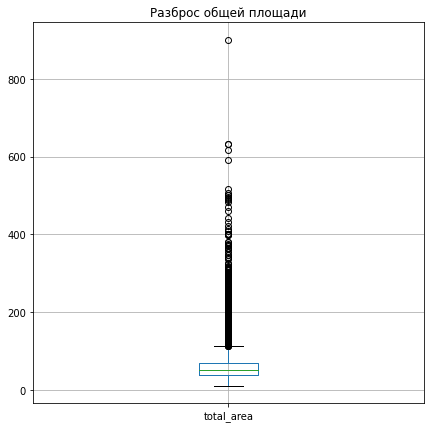

In [ ]:
# 3) total_area 

df.boxplot(column = 'total_area',figsize=(7,7));
plt.title('Разброс общей площади')
plt.show()

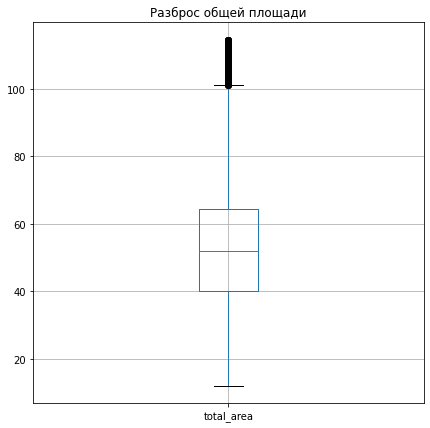

In [ ]:
Q1 =  df['total_area'].quantile(0.25)
Q3 = df['total_area'].quantile(0.75)
IQR = Q3 - Q1

#bb = Q1-1.5*IQR
#ub = Q3+1.5*IQR
#df = df.query('@bb < total_area < @ub')

med = df['total_area'].median()
df['total_area'] = df['total_area'].where(df['total_area'] < (Q3+1.5*IQR),med)
df['total_area'] = df['total_area'].where(df['total_area'] > (Q1-1.5*IQR),med)

#df = df[df['total_area']< (Q3+1.5*IQR) ]
#df = df[df['total_area']> (Q1-1.5*IQR) ]

df.boxplot(column = 'total_area',figsize=(7,7));
plt.title('Разброс общей площади')
plt.show()


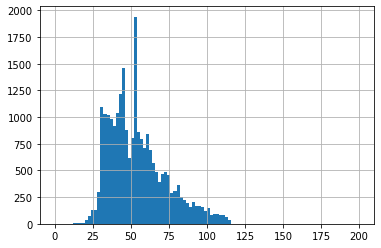

In [ ]:
df['total_area'].hist(bins=100,range=(0,200));

In [ ]:
df['total_area'].isna().sum()

0

In [ ]:
df['total_area'].describe()

count    23699.000000
mean        54.241168
std         18.878688
min         12.000000
25%         40.000000
50%         52.000000
75%         64.500000
max        114.600000
Name: total_area, dtype: float64

- *3) total_area - пропусков нет, выбросы заменены на NaN, тип данных float64* -   **good**


- *4) first_day_exposition - пропусков нет, тип данных object* - **good**
- *5) rooms - пропусков нет, тип данных int64* - **good**

In [ ]:
# 6) ceiling_height - тип данных корректен, но есть пропуски

df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [ ]:
df['ceiling_height'].isna().sum()

9195

<br> *9195 проропусков, надо понять чем их заменить, так же есть выбросы 100 метров, есть потолки по 1 метр*

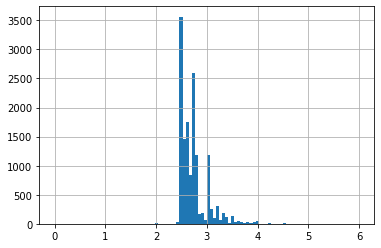

In [ ]:
df['ceiling_height'].hist(bins=100,range=(0,6));

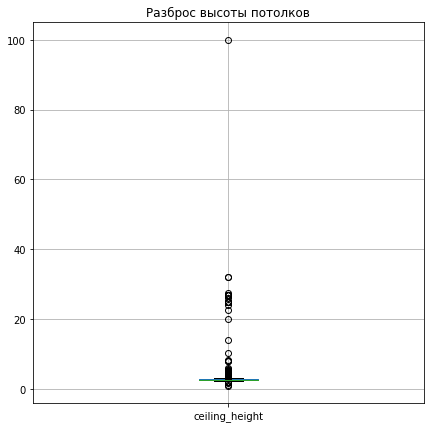

In [ ]:
df.boxplot(column = 'ceiling_height',figsize=(7,7));
plt.title('Разброс высоты потолков')
plt.show()

In [ ]:
Q1 =df['ceiling_height'].quantile(0.25)
Q3 = df['ceiling_height'].quantile(0.75)
IQR = Q3 - Q1

med = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] < (Q3+1.5*IQR) )
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] > (Q1-1.5*IQR) )

#bb = Q1-1.5*IQR
#ub = Q3+1.5*IQR
#df = df.query('@bb < ceiling_height < @ub')

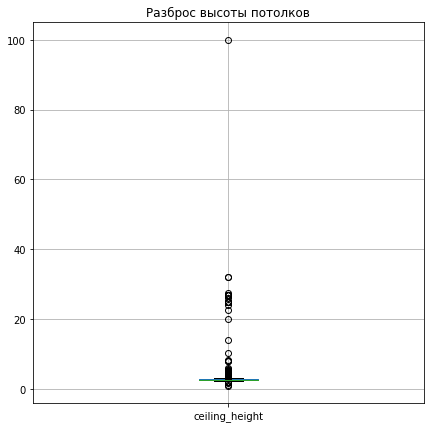

In [ ]:
df.boxplot(column = 'ceiling_height',figsize=(7,7));
plt.title('Разброс высоты потолков')
plt.show()

In [ ]:
df['ceiling_height'].count()

14504

In [ ]:
df['ceiling_height'].isna().sum()

9195

In [ ]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

- *6) ceiling_height - пропуски есть, выбросов нет, тип данных float64* -   **good**

In [ ]:
# 7) floors_total

df['floors_total'].isna().sum()

86

In [ ]:
df['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [ ]:
df['floors_total'] = df['floors_total'].fillna(9)
df['floors_total'].isna().sum()

0

In [ ]:
df['floors_total'].describe()

count    23699.000000
mean        10.667750
std          6.585961
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<br> *человек мог забыть указать общее количество этажей*
<br> *пустые значения заменим медианой, среднии значения изменились на сотую*
- *7) floors_total - пропусков нет, тип данных float64* -   **good**

In [ ]:
# 8) living_area

df['living_area'].isna().sum()

1903

In [ ]:
df['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [ ]:
# df['living_area'] = df['living_area'].fillna(29)

df['living_area'].isna().sum()

1903

In [ ]:
df['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<br> *пропущенных значений 1903*
<br> *заменять их медианой не корректно*
<br> *это сильно исказит будущие корреляции с этой величеной*
<br> *пропуски оствляем как есть*
<br> 
- *8) living_area - пропуски есть, тип данных float64* -   **good**
- *9) floor - пропусков нет, тип данных int64* -   **good**


In [ ]:
# 10) is_apartment

df['is_apartment'].value_counts(dropna=False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

<br> 
<br> *так как пропусков очень много, решил ни чего не менять*
<br>
- *10) is_apartment - пропусков очень много, тип данных object* -   **bad**
- *11) studio - пропусков нет, тип данных bool* -   **good**
- *12) open_plan - пропусков нет, тип данных bool* -   **good**


In [ ]:
# 13) kitchen_area

df['kitchen_area'].isna().sum()

2278

In [ ]:
df['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [ ]:
#df['kitchen_area'] = df['kitchen_area'].fillna(9)

df['kitchen_area'].isna().sum()

2278

In [ ]:
df['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<br> *пропущенных значений 2278*
<br> *если заменим их медианой, сильно исказим кореляции с этой величиной*
<br> *пропуски оставим*
<br> 
<br> 
- *13) kitchen_area - пропуски есть, тип данных float64* -   **good**

In [ ]:
# 14) balcony

df['balcony'].isna().sum()

11519

In [ ]:
df['balcony'].describe()

count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

In [ ]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].isna().sum()

0

<br> *пропусков 11519, это около половины всех значений*
<br> *данная графа рассматривает площать балкона*
<br> *возможно отсутствие значения, подразумевает отсутствие самого балкона*
<br> *логично будет заменить NaN на 0*
<br> 
<br> 
- *14) balcony - пропусков нет, тип данных float64* -   **good**

In [ ]:
# 15) locality_name

df['locality_name'].isna().sum()

49

In [ ]:
df['locality_name'] = df['locality_name'].fillna('данных нет')
df['locality_name'].isna().sum()

0

<br> *есть 49 пропусков*
<br> *это адреса*
<br> *заменим их на строчку - "данных нет"*
<br> 
- *15) locality_name - пропусков нет, тип данных object* -   **good**

In [ ]:
# 16) airports_nearest

df['airports_nearest'].isna().sum()

5542

In [ ]:
df['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [ ]:
#df['airports_nearest'] = df['airports_nearest'].fillna(25985)
df['airports_nearest'].isna().sum()

5542

In [ ]:
df['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<br> *расстояние до аэропорта*
<br> *есть 5542 пропусков*
<br> *заменять пропуски на какие либо значения приведут к сильным искажениям*
<br> *так как корреляции можно проводить с NaN, лучше оставить пропуски как есть*
<br> *чем заменять их на медиану или среднее*
<br> *пропуски оставляем*
<br>
<br> 
- *16) airports_nearest - пропуски есть, тип данных float64* -   **good** 

In [ ]:
# 17) cityCenters_nearest

df['cityCenters_nearest'].isna().sum()

5519

In [ ]:
df['cityCenters_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [ ]:
#df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(13002)

df['cityCenters_nearest'].isna().sum()

5519

<br> *расстояние до центра города*
<br> *пропуски оставляем*
<br> *замена на среднее или медиану сильно исказит возможные кореляции с этой величиной в дальнейшем*
<br> 
<br> 
- *17) cityCenters_nearest - пропуски есть, тип данных float64* -   **good** 


In [ ]:
# 18) parks_around3000

df['parks_around3000'].isna().sum()

5518

In [ ]:
df['parks_around3000'].describe()

count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [ ]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['parks_around3000'].isna().sum()

0

In [ ]:
df['parks_around3000'].describe()

count    23699.000000
mean         0.469049
std          0.748534
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

<br> *можно предположить что пропущенное значение в графе количество парков на расстоянии 3000м,*
<br> *означает - ни одного парка,*
<br> *поэтому смело меняем NaN на нули*
<br> 
- *18) parks_around3000 - пропусков нет, тип данных float64* -   **good** 

In [ ]:
# 19) parks_nearest

df['parks_nearest'].isna().sum()

15620

In [ ]:
df['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<br> *расстояние до парка*
<br> *пропуски означают что парков по близости нет*
<br> *если пустые значение привести к 0, или к сверх большому значению, то это сильно исказит картину, для тех у кого парк рядом*
<br> *менять на среднии или медиану то же плохая идея, количество пропусков более 70%* 
<br> *что тоже сильно исказит цифры*
<br> *оставлю пропуски как есть*
<br> 
- *19) parks_nearest - пропуски есть, тип данных float64* -   **norm** 

In [ ]:
# 20) ponds_around3000

df['ponds_around3000'].isna().sum()

5518

In [ ]:
df['ponds_around3000'].describe()

count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [ ]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['ponds_around3000'].isna().sum()

0

In [ ]:
df['ponds_around3000'].describe()

count    23699.000000
mean         0.590911
std          0.883999
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

<br> *количество водоемов на расстоянии 3000 метров*
<br> *та же истроия что и с парками*
<br> *меням NaN на нули*
<br> 
- *20) ponds_around3000 - пропусков нет, тип данных float64* -   **good** 

In [ ]:
# 21) ponds_nearest

df['ponds_nearest'].isna().sum()

14589

In [ ]:
df['ponds_nearest'].describe()

count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

<br> *расстояние до водоема*
<br> *та же истроия что и с парками*
<br> *оставляем пропуски как есть*
<br>
- *21) ponds_nearest - пропуски есть, тип данных float64* -   **norm** 

In [ ]:
# 22) days_exposition

df['days_exposition'].isna().sum()

3181

In [ ]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<br> *дата снятия с продажи*
<br> *если значение пусто, значит объект еще в продаже*
<br> *пустое значение оставляем*
<br> 
- *22) days_exposition - пропуски есть, тип данных float64* -   **norm** 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [ ]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.000000
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.000000
locality_name           0.000000
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.000000
parks_nearest           0.659100
ponds_around3000        0.000000
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

## 2.2  Вывод


<br> - *типы данных заменены*
<br> - *пустые значения по возможности убраны*
<br> - *столбец - is_apartment, слишком много пропусков, странное значение 2.6, убран из дальнейшего анализа* 

# Шаг 3. Посчитаем и добавим в таблицу новые данные

## 3.1 Создадим столбец цена за метр квадратный - price_meter

In [ ]:
df['price_meter'] = df['last_price'] / df['total_area']
df['price_meter'].describe()

count    2.369900e+04
mean     1.200856e+05
std      2.035539e+05
min      1.118349e+02
25%      7.717391e+04
50%      9.583333e+04
75%      1.166667e+05
max      1.467308e+07
Name: price_meter, dtype: float64

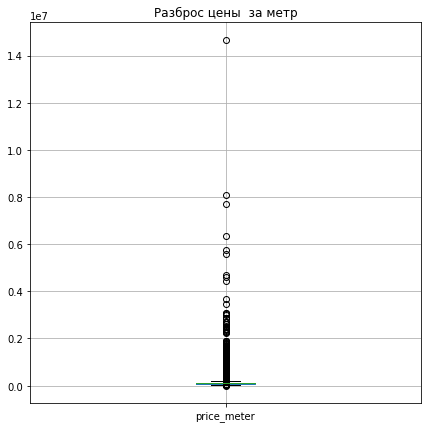

In [ ]:
df.boxplot(column = 'price_meter',figsize=(7,7));
plt.title('Разброс цены  за метр')
plt.show()

In [ ]:
Q1 =df['price_meter'].quantile(0.25)
Q3 = df['price_meter'].quantile(0.75)
IQR = Q3 - Q1

df['price_meter'] = df['price_meter'].where(df['price_meter'] < (Q3+1.5*IQR) )
df['price_meter'] = df['price_meter'].where(df['price_meter'] > (Q1-1.5*IQR) )

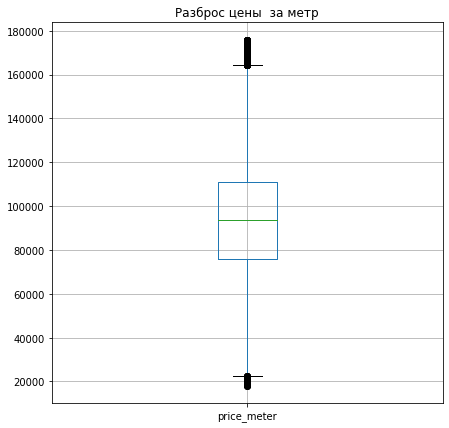

In [ ]:
df.boxplot(column = 'price_meter',figsize=(7,7));
plt.title('Разброс цены  за метр')
plt.show()

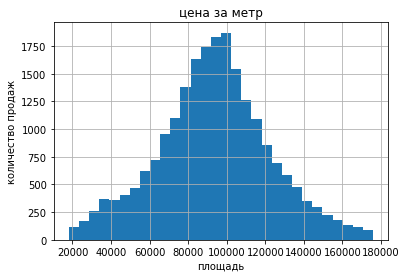

In [ ]:
df['price_meter'].hist(bins=30);
plt.title('цена за метр')
#plt.xlim(0,1000000)
plt.xlabel('площадь')
plt.ylabel('количество продаж')
plt.show()

*распределение цены за метр - это нормальное распределение*

## 3.2 Создадим графы день недели публикации, месяц и год

In [ ]:
type(df['first_day_exposition'][5])

str

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
type(df['first_day_exposition'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['weekday'].sample(5)

23306    0
376      1
7988     6
9407     5
20436    2
Name: weekday, dtype: int64

In [ ]:
df['year'] = df['first_day_exposition'].dt.year
df['year'].sample(5)

15203    2018
20743    2018
14666    2017
14128    2016
19374    2018
Name: year, dtype: int64

In [ ]:
df['month'] = df['first_day_exposition'].dt.month
df['month'].sample(5)

15416    8
11840    8
794      4
19305    3
8201     4
Name: month, dtype: int64

## 3.3 Создадим столбец - категории этажей

In [ ]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_category'] = df.apply(floor_category, axis=1)
df['floor_category'].value_counts()

другой       17441
последний     3341
первый        2917
Name: floor_category, dtype: int64

*вышло три категории*

## 3.4 Добавим в таблицу соотношение жилой и общей площади, а также отношение площади кухни к общей

In [ ]:
df['living_to_total'] = df['living_area'] / df['total_area']
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area']
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,year,month,floor_category,living_to_total,kitchen_to_total
17092,4,5600000.0,45.0,2016-06-20,1,2.74,17.0,21.00,10,NaN,False,False,12.00,5.0,Санкт-Петербург,49338.0,16224.0,1.0,226.0,0.0,NaN,702.0,124444.444444,0,2016,6,другой,0.466667,0.266667
21926,10,6500000.0,78.9,2017-09-05,3,NaN,16.0,46.60,16,NaN,False,False,15.10,0.0,Санкт-Петербург,33546.0,12178.0,0.0,NaN,0.0,NaN,86.0,82382.762991,1,2017,9,последний,0.590621,0.191381
9228,5,4000000.0,83.4,2017-12-18,3,NaN,12.0,52.26,5,False,False,False,10.42,1.0,деревня Малые Колпаны,NaN,NaN,0.0,NaN,0.0,NaN,111.0,47961.630695,0,2017,12,другой,0.626619,0.124940
886,14,3970000.0,39.7,2018-09-28,1,NaN,19.0,14.80,1,NaN,False,False,14.30,0.0,Санкт-Петербург,32525.0,8665.0,0.0,NaN,1.0,176.0,24.0,100000.000000,4,2018,9,первый,0.372796,0.360202
23288,17,6950000.0,62.0,2018-08-14,2,NaN,5.0,38.00,1,NaN,False,False,5.00,0.0,Санкт-Петербург,22966.0,4459.0,0.0,NaN,1.0,841.0,60.0,112096.774194,1,2018,8,первый,0.612903,0.080645


### Описание данных
 - *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м)
 - *balcony* — число балконов
 - *ceiling_height* — высота потолков (м)
 - *cityCenters_nearest* — расстояние до центра города (м)
 - *days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
 - *first_day_exposition* — дата публикации
 - *floor* — этаж
 - *floors_total* — всего этажей в доме
 - *is_apartment* — апартаменты (булев тип)
 - *kitchen_area* — площадь кухни в квадратных метрах (м²)
 - *last_price* — цена на момент снятия с публикации
 - *living_area* — жилая площадь в квадратных метрах(м²)
 - *locality_name* — название населённого пункта
 - *open_plan* — свободная планировка (булев тип)
 - *parks_around3000* — число парков в радиусе 3 км
 - *parks_nearest* — расстояние до ближайшего парка (м)
 - *ponds_around3000* — число водоёмов в радиусе 3 км
 - *ponds_nearest* — расстояние до ближайшего водоёма (м)
 - *rooms* — число комнат
 - *studio* — квартира-студия (булев тип)
 - *total_area* — площадь квартиры в квадратных метрах (м²)
 - *total_images* — число фотографий квартиры в объявлении

### Добавили семь новых столбцов:
- *price_meter* - цена за метр жилья
- *weekday* - день недели когда обьявление выставели
- *year* - год обьявления
- *month* - месяц обьявления
- *floor_category* - категория этажа (высотность)
- *living_to_total* - отношение жилой площади к общей
- *kitchen_to_total* - отношение кухни к общей площади 

## 3.5 Еще раз проверим параметры: площадь, цена, число комнат, высота потолков

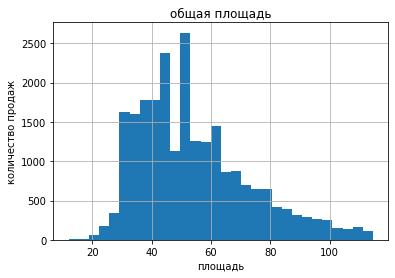

In [ ]:
df['total_area'].hist(bins=30);
plt.title('общая площадь')
plt.xlabel('площадь')
plt.ylabel('количество продаж')
plt.show()

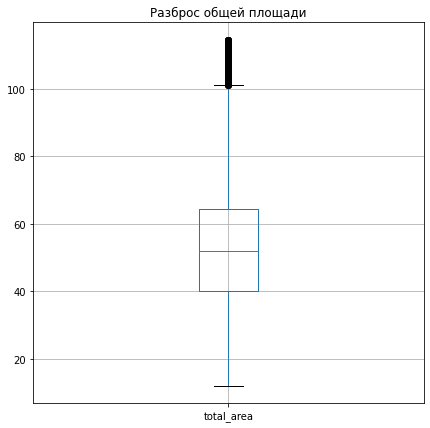

In [ ]:
df.boxplot(column = 'total_area',figsize=(7,7));
plt.title('Разброс общей площади')
plt.show()

*общая площадь - распределение нормальное*

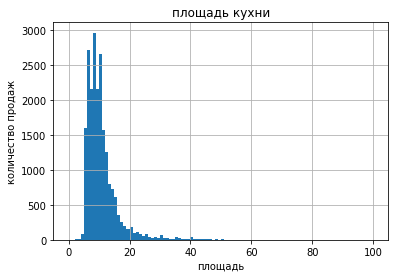

In [ ]:
df['kitchen_area'].hist(bins=100,range=(0,100));
plt.title('площадь кухни')
plt.xlabel('площадь')
plt.ylabel('количество продаж')
plt.show()

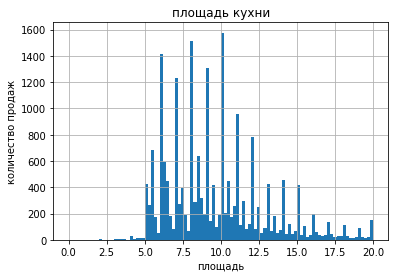

In [ ]:
df['kitchen_area'].hist(bins=100,range=(0,20));
plt.title('площадь кухни')
plt.xlabel('площадь')
plt.ylabel('количество продаж')
plt.show()

<br> *площадь кухни - при увиличении масштаба видно, что часто используют стандартные(часто применяемые) цифры* 
<br> *в целом площадь кухни - это нормальное распределение*

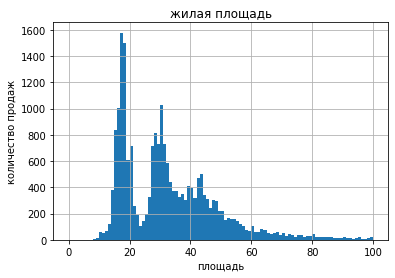

In [ ]:
df['living_area'].hist(bins=100,range=(0,100));
plt.title('жилая площадь')
plt.xlabel('площадь')
plt.ylabel('количество продаж')
plt.show()

In [ ]:
df['living_area'].value_counts().sort_values(ascending=False)

18.00    882
17.00    675
30.00    598
16.00    486
20.00    481
        ... 
36.57      1
41.98      1
40.59      1
34.41      1
30.61      1
Name: living_area, Length: 1782, dtype: int64

In [ ]:
df['living_area'].median()

30.0

<br> *график жилой площади имеет три вершины, это скорее всего свидетельствует о том,*
<br> *что в этот массив данных поступали разные данные, кто то указывал жилую площадь, кто то скорее всего общую площадь*
<br> *так же это может свидетельствовать о взаимосвязи жилой площади, и количества комнат*
<br> *чем больше комнат, тем больше площадь*

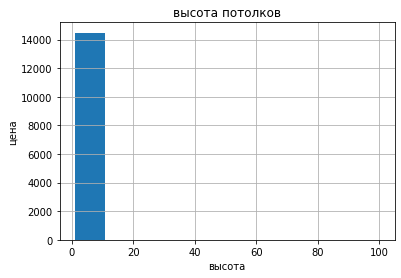

In [ ]:
df['ceiling_height'].hist(bins=10);
plt.title('высота потолков')
plt.xlabel('высота')
plt.ylabel('цена')
plt.show()

*с выстотой потолков мы уже разобрались, распределение вроде нормальное*

In [ ]:
df['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

In [ ]:
df['rooms'] = df['rooms'].replace(0, 1)

<br> 
<br> *ноль скорее всего означает квартиру-студию, или однокомнатную квартиру, заменим их на 1*


In [ ]:
# из-за изменений в общей и жилой площадях, надо перещитать отношения площадей

df['living_to_total'] = df['living_area'] / df['total_area']
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area']

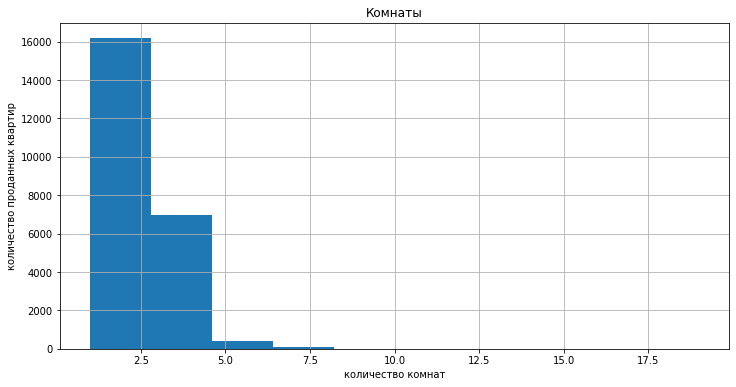

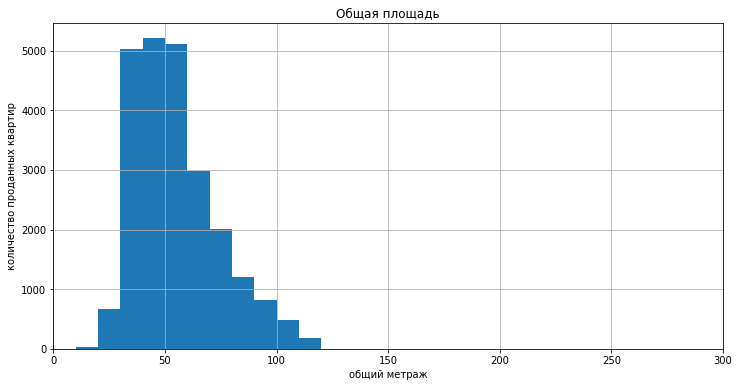

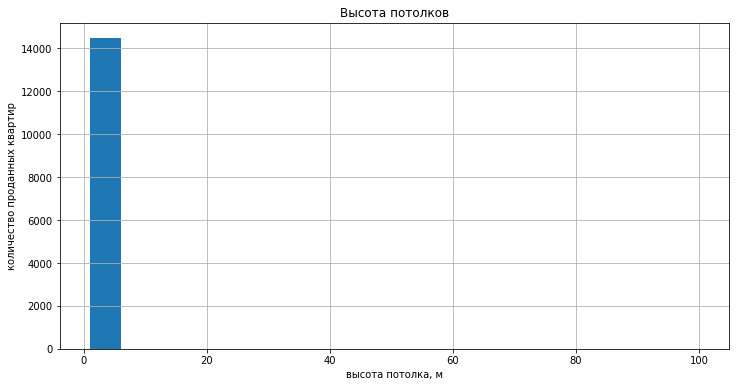

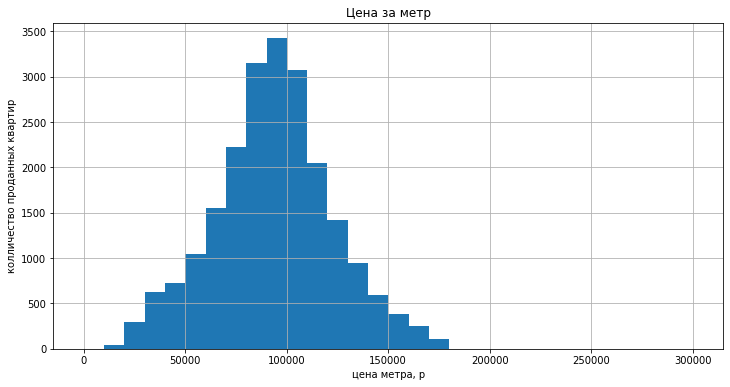

In [ ]:
# подведем итог, выведим гистограммы по rooms, total_area, ceiling_height, и price_meter

print()
df['rooms'].plot(kind='hist',bins=10, grid=True, title = 'Комнаты',figsize=(12,6));
plt.xlabel('количество комнат') 
plt.ylabel('количество проданных квартир')
plt.show()
print()
df['total_area'].plot(kind='hist',bins=50, grid=True, title = 'Общая площадь',figsize=(12,6), range=(0,500));
plt.xlim(0,300)
plt.xlabel('общий метраж') 
plt.ylabel('количество проданных квартир')
plt.show()
print()
df['ceiling_height'].plot(kind='hist',bins=20, grid=True, title = 'Высота потолков',figsize=(12,6));
plt.xlabel('высота потолка, м') 
plt.ylabel('количество проданных квартир')
plt.show()
print()
df['price_meter'].plot(kind='hist',bins=30,range=(0,300000),grid=True, title = 'Цена за метр',figsize=(12,6));
plt.xlabel('цена метра, р') 
plt.ylabel('колличество проданных квартир')
plt.show()

## 3.6  Вывод


<br> - *добавили семь столбцов новой информации*
<br> - *убрали аномалии и выбросы*
<br> - 
<br> - *были выведены гистограммы по основным показателям*
<br> - *DataFrame причесан и готов к иследовательскому анализу* 
<br> 

# Шаг 4. Проведем исследовательский анализ данных

## 4.1 Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64



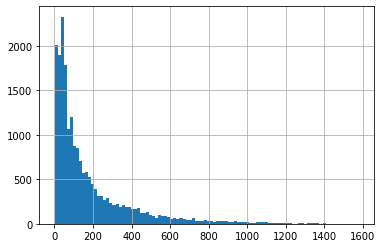

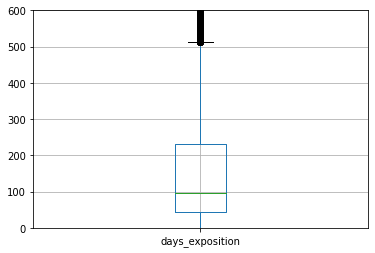

In [ ]:
print(df['days_exposition'].describe())
print()
df['days_exposition'].hist(bins=100);
plt.show()
plt.ylim(0,600)
df.boxplot('days_exposition');
plt.show()

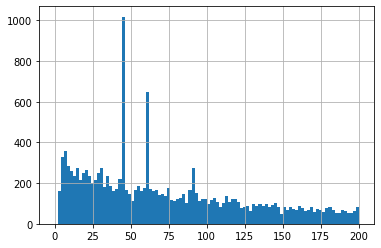

In [ ]:
df['days_exposition'].hist(bins=100,range=(0,200));

In [ ]:
df['days_exposition'].value_counts().sort_values(ascending=False).head(10)

45.0    880
60.0    538
7.0     234
30.0    208
90.0    204
4.0     176
3.0     158
5.0     152
14.0    148
9.0     143
Name: days_exposition, dtype: int64

<BR> *среднее время продажи составляет 180 дней, по медиане 95*
<BR> *разница почти в два раза*
<BR> *стандартное отклонение 219 дней, это очень много*
<BR> *означает что время продажи больтает на большом растоянии от среднего занчения*
<BR> *по количеству продаж видно что есть стандарные числа, 30, 45, 60 дней*
<BR> *долгой продажей можно назвать диапазон за верхним усом, коробки с усами, это около 500 дней*
<BR> *быстрой продажей, соответственно можно назавать полтора месяц, если продажа прошла за 45 дней, ее можно назвать быстрой* 

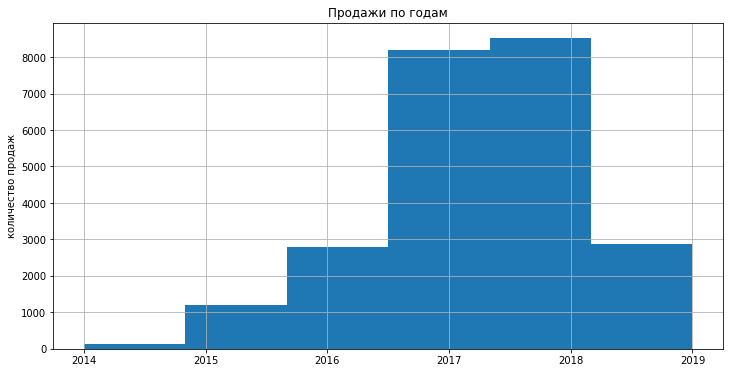

In [ ]:
df['year'].plot(kind='hist',bins=6,grid=True, title = 'Продажи по годам',figsize=(12,6));
plt.ylabel('количество продаж')
plt.show()

<BR> *в 2016/2018 был сильный рост продаж*
<BR> *в последний год 2019, информация не полная*
<BR> *в целом, с каждым годом, количество продаж жилой недвижимости возрастает*
  

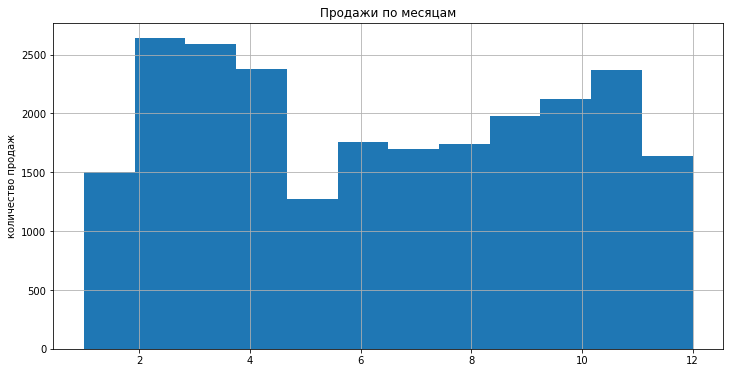

In [ ]:
df['month'].plot(kind='hist',bins=12,grid=True, title = 'Продажи по месяцам',figsize=(12,6));
plt.ylabel('количество продаж')
plt.show()

<BR> *в первом квартале продажи идут лучше*
<BR> *май, самый провальный месяц*
<BR> *в начале лета продажи начинают возрастать*
<BR> *в декабре так же наблюдается спад продаж*


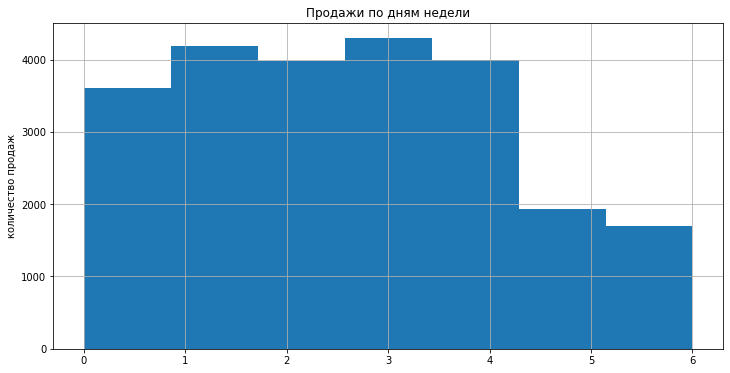

In [ ]:
df['weekday'].plot(kind='hist',bins=7,grid=True, title = 'Продажи по дням недели',figsize=(12,6));
plt.ylabel('количество продаж')
plt.show()

<BR> 
<BR> *по выходным сделки заключают реже*


## 4.2 Уберем редкие, выбивающиеся значения. Опишем особенности.

In [ ]:
df['days_exposition'].value_counts().sort_values(ascending=False).head(10)

45.0    880
60.0    538
7.0     234
30.0    208
90.0    204
4.0     176
3.0     158
5.0     152
14.0    148
9.0     143
Name: days_exposition, dtype: int64

In [ ]:
df['year'].value_counts().sort_values(ascending=False)

2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: year, dtype: int64

In [ ]:
df = df.query('year != 1970')
df['year'].value_counts().sort_values(ascending=False)

2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: year, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Вроде разобрался. Все поправил.**

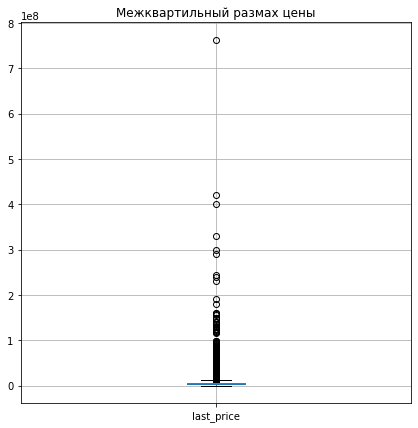

In [ ]:
# удалим выбросы в цене 

df.boxplot(column='last_price',figsize=(7,7));
plt.title('Межквартильный размах цены')
plt.show()

In [ ]:
df['last_price'].count()

23699

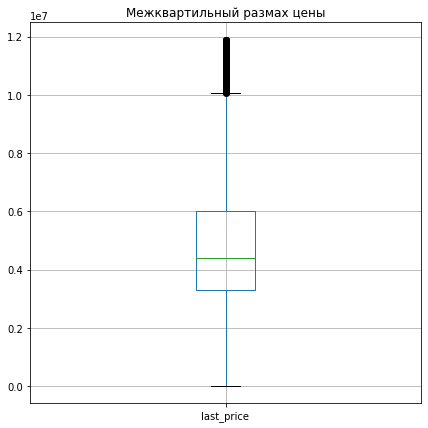

In [ ]:
Q1 =  df['last_price'].quantile(0.25)
Q3 = df['last_price'].quantile(0.75)
med = df['last_price'].median()
IQR = Q3 - Q1
df = df[df['last_price'] > (Q1 - 1.5*IQR)]
df = df[df['last_price'] < (Q3 + 1.5*IQR)]
df.boxplot(column='last_price',figsize=(7,7));
plt.title('Межквартильный размах цены')
plt.show()

In [ ]:
df['last_price'].count()

21638

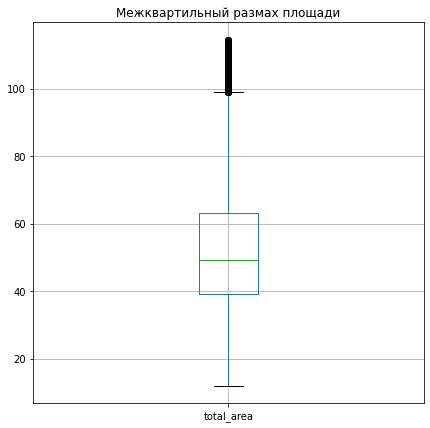

In [ ]:
# удалим выбросы в общей площаде 

df.boxplot(column='total_area',figsize=(7,7));
plt.title('Межквартильный размах площади')
plt.show()

In [ ]:
df['total_area'].count()

21638

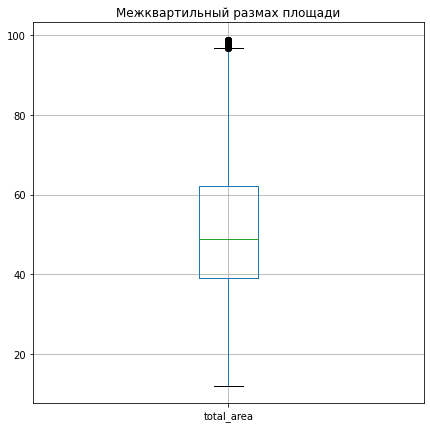

In [ ]:
Q1 =  df['total_area'].quantile(0.25)
Q3 = df['total_area'].quantile(0.75)
med = df['total_area'].median()
IQR = Q3 - Q1
df = df[df['total_area'] > (Q1 - 1.5*IQR)]
df = df[df['total_area'] < (Q3 + 1.5*IQR)]
df.boxplot(column='total_area',figsize=(7,7));
plt.title('Межквартильный размах площади')
plt.show()

In [ ]:
df.count()

total_images            21302
last_price              21302
total_area              21302
first_day_exposition    21302
rooms                   21302
ceiling_height          12868
floors_total            21302
living_area             19636
floor                   21302
is_apartment             2483
studio                  21302
open_plan               21302
kitchen_area            19254
balcony                 21302
locality_name           21302
airports_nearest        15838
cityCenters_nearest     15849
parks_around3000        21302
parks_nearest            6564
ponds_around3000        21302
ponds_nearest            7605
days_exposition         18730
price_meter             20929
weekday                 21302
year                    21302
month                   21302
floor_category          21302
living_to_total         19636
kitchen_to_total        19254
dtype: int64


## 4.3 Какие факторы больше всего влияют на стоимость квартиры?

### 4.3.1 посмотрим зависимости цены к 'price_meter','rooms','floor_category', и 'cityCenters_nearest'

In [ ]:
df_lp_cor = df[['price_meter','rooms','floor_category', 'cityCenters_nearest','last_price','ceiling_height']]


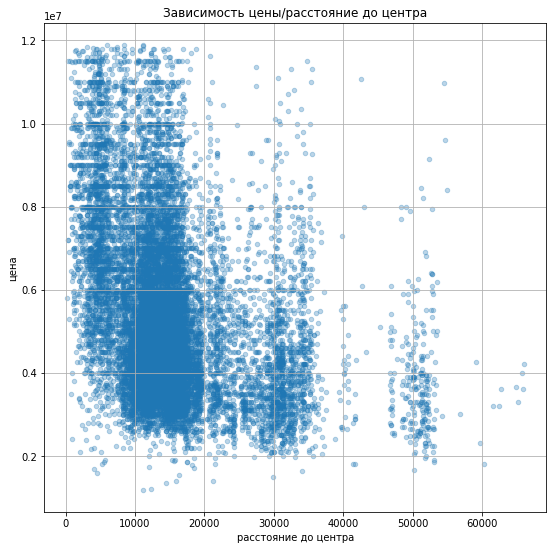

In [ ]:
df_lp_cor.plot(x='cityCenters_nearest',y='last_price',kind='scatter',title='Зависимость цены/расстояние до центра',figsize=(9,9),grid=True,alpha=0.3);
plt.xlabel('расстояние до центра')
plt.ylabel('цена')
plt.show()

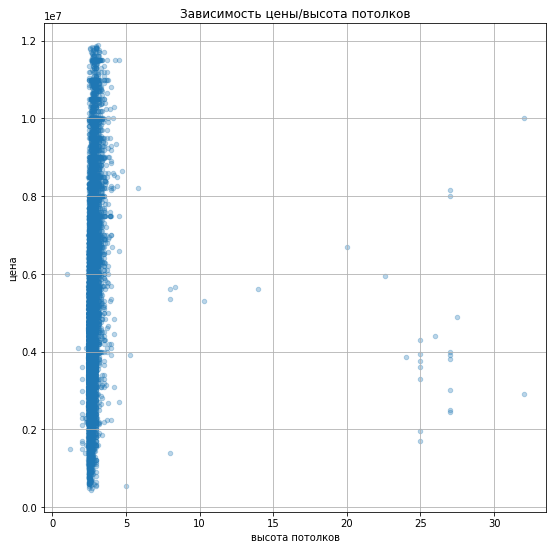

In [ ]:
df_lp_cor.plot(x='ceiling_height',y='last_price',kind='scatter',title='Зависимость цены/высота потолков',figsize=(9,9),grid=True,alpha=0.3);
plt.xlabel('высота потолков')
plt.ylabel('цена')
plt.show()

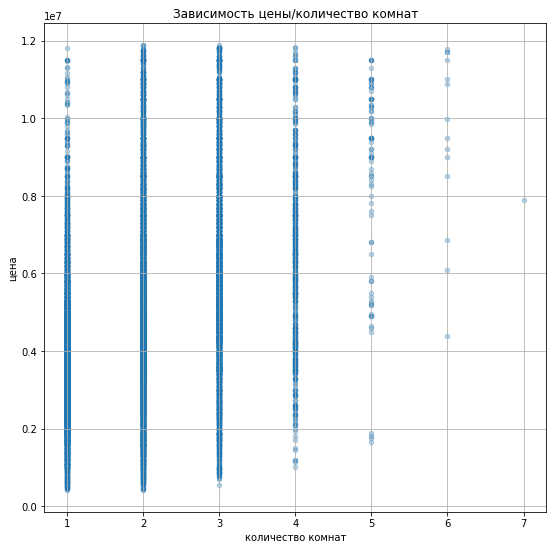

In [ ]:
df_lp_cor.plot(x='rooms',y='last_price',kind='scatter',title='Зависимость цены/количество комнат',figsize=(9,9),grid=True,alpha=0.3);
plt.xlabel('количество комнат')
plt.ylabel('цена')
plt.show()

In [ ]:
df_lp_cor.corr()['last_price']

price_meter            0.645262
rooms                  0.425945
cityCenters_nearest   -0.342035
last_price             1.000000
ceiling_height         0.088780
Name: last_price, dtype: float64

<BR> *наблюдается хорошая взяимосвязь цены и цены за метр, это очень логично*
<BR> *так же не большая взаимосвязь с количеством комнат, чем больше комнат, тем больше и цена*
<BR> *высотой потолков, и отдаленностью от центра*

### 4.3.2 Зависимость цены квартиры от этажа

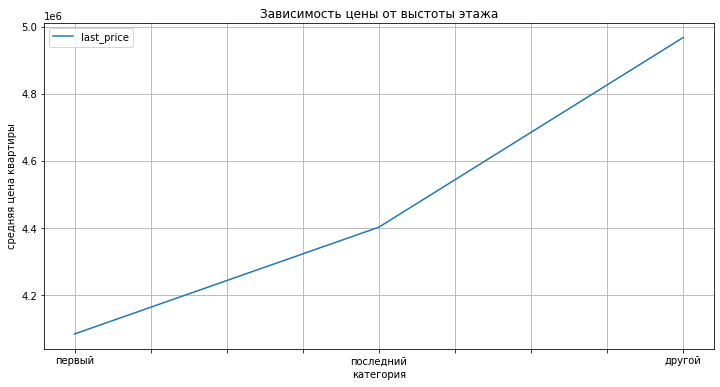

In [ ]:
price_to_category = df.pivot_table(index = 'floor_category', values='last_price',aggfunc='mean').sort_values(by = 'last_price')
price_to_category.plot( grid=True,title = 'Зависимость цены от выстоты этажа',figsize=(12,6));
plt.xlabel('категория');
plt.ylabel('средняя цена квартиры');

<BR> *зависимость цены квартиры от категории высоты этажа*
<BR> *чем выше, тем престижней*

### 4.3.3 Посмотрим зависимость цены квартиры от времени продажи(месяца, дня недели, года)

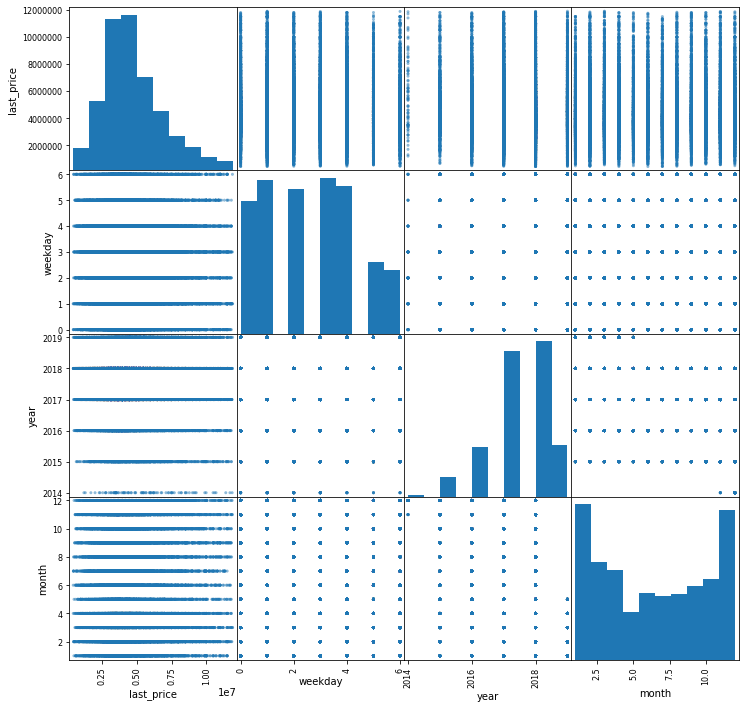

In [ ]:
price_to_date = df[['last_price','weekday','year','month']]
pd.plotting.scatter_matrix(price_to_date, figsize=(12,12));

In [ ]:
price_to_date.corr()

,last_price,weekday,year,month
last_price,1.000000,-0.011261,0.005293,0.003388
weekday,-0.011261,1.000000,-0.003573,0.011704
year,0.005293,-0.003573,1.000000,-0.267015
month,0.003388,0.011704,-0.267015,1.000000


<BR> *в основном ни какой связи между временем продажи и ценой нет*
<BR> *коэффициент корреляции около нуля, по всем показателям*
<BR> *только незначительня, еле заметная связь, года к месяцу, -0.26*

### 4.3.4 Выделим населённые пункты с самой высокой и низкой стоимостью жилья

In [ ]:
dfx = df['locality_name'].value_counts().sort_values(ascending=False).head(10)
dfx

Санкт-Петербург      13467
посёлок Мурино         522
посёлок Шушары         434
Всеволожск             392
Пушкин                 336
Колпино                332
посёлок Парголово      325
Гатчина                302
деревня Кудрово        297
Выборг                 230
Name: locality_name, dtype: int64

In [ ]:
df.groupby('locality_name')['price_meter'].agg(['count','mean']).sort_values(by='count',ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,13221,105115.956367
посёлок Мурино,522,85752.189195
посёлок Шушары,432,78895.156231
Всеволожск,391,67516.949795
Пушкин,335,100662.083226
Колпино,332,75609.770832
посёлок Парголово,325,90683.590815
Гатчина,301,69008.985706
деревня Кудрово,297,92392.915308


In [ ]:
df.groupby('locality_name')['last_price'].agg(['count','max','min']).sort_values(by='count',ascending=False).head(10).sort_values(by='max',ascending=False).head(10)


,count,max,min
locality_name,,,
Санкт-Петербург,13467,11894400.0,1190000.0
Пушкин,336,11350000.0,1990000.0
Всеволожск,392,11000000.0,965780.0
посёлок Шушары,434,10700000.0,1500000.0
деревня Кудрово,297,10000000.0,1800000.0
Гатчина,302,9500000.0,850000.0
Выборг,230,9200000.0,600000.0
посёлок Парголово,325,9140000.0,1400000.0
Колпино,332,8600000.0,2100000.0


In [ ]:
df.groupby('locality_name')['last_price'].agg(['count','max','min']).sort_values(by='count',ascending=False).head(10).sort_values(by='min',ascending=True).head(10)

,count,max,min
locality_name,,,
Выборг,230,9200000.0,600000.0
Гатчина,302,9500000.0,850000.0
Всеволожск,392,11000000.0,965780.0
Санкт-Петербург,13467,11894400.0,1190000.0
посёлок Парголово,325,9140000.0,1400000.0
посёлок Шушары,434,10700000.0,1500000.0
посёлок Мурино,522,8500000.0,1730000.0
деревня Кудрово,297,10000000.0,1800000.0
Пушкин,336,11350000.0,1990000.0


<BR> *больше всего объявлений в Санкт-Петербурге*
<BR> *самое дорогое жилье из 10 самых продоваемых населенных пунктов находится в Санкт-Петербурге*
<BR> *самое дешовое жилье из 10 самых продоваемых населенных пунктов находится в Выборге*


## 4.4 Выясним, какая область входит в центр города.

In [ ]:
df_spb = df.query('locality_name == "Санкт-Петербург"')
df_spb['cityCenters_km'] = df_spb['cityCenters_nearest'] / 1000
df_spb['cityCenters_km'] = df_spb['cityCenters_km'].round()
df_spb.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,year,month,floor_category,living_to_total,kitchen_to_total,cityCenters_km
13639,2,5900000.0,69.0,2017-12-14,3,NaN,25.0,37.00,9,NaN,False,False,10.0,0.0,Санкт-Петербург,48847.0,16685.0,0.0,NaN,0.0,NaN,219.0,85507.246377,3,2017,12,другой,0.536232,0.144928,17.0
2584,17,4150000.0,36.7,2017-09-28,1,2.55,10.0,17.70,3,NaN,False,False,8.3,2.0,Санкт-Петербург,15236.0,11043.0,0.0,NaN,1.0,934.0,81.0,113079.019074,3,2017,9,другой,0.482289,0.226158,11.0
12120,9,3200000.0,33.4,2017-04-18,1,NaN,9.0,20.26,5,NaN,False,False,5.4,0.0,Санкт-Петербург,17683.0,17591.0,1.0,577.0,0.0,NaN,195.0,95808.383234,1,2017,4,другой,0.606587,0.161677,18.0
16567,5,4500000.0,48.1,2017-05-17,2,NaN,9.0,31.70,5,NaN,False,False,8.2,0.0,Санкт-Петербург,12666.0,11888.0,1.0,258.0,0.0,NaN,14.0,93555.093555,2,2017,5,другой,0.659044,0.170478,12.0
5398,17,5250000.0,45.9,2018-01-10,1,2.75,16.0,18.80,11,NaN,False,False,14.5,1.0,Санкт-Петербург,14069.0,12621.0,0.0,NaN,0.0,NaN,82.0,114379.084967,2,2018,1,другой,0.409586,0.315904,13.0
20482,9,5832558.0,53.3,2017-12-20,1,NaN,16.0,NaN,2,NaN,False,False,NaN,0.0,Санкт-Петербург,36897.0,10647.0,1.0,183.0,0.0,NaN,NaN,109428.855535,2,2017,12,другой,NaN,NaN,11.0
8654,12,8400000.0,81.5,2019-02-14,3,3.60,4.0,40.00,3,NaN,False,False,26.0,0.0,Санкт-Петербург,26767.0,5469.0,2.0,486.0,1.0,165.0,23.0,103067.484663,3,2019,2,другой,0.490798,0.319018,5.0
9590,11,8420000.0,50.0,2019-04-12,2,3.20,5.0,28.90,3,NaN,False,False,9.1,0.0,Санкт-Петербург,22435.0,3084.0,2.0,742.0,1.0,69.0,NaN,168400.000000,4,2019,4,другой,0.578000,0.182000,3.0
2658,9,5600000.0,56.0,2019-04-23,3,2.52,5.0,38.00,4,NaN,False,False,5.0,0.0,Санкт-Петербург,39485.0,11179.0,1.0,373.0,1.0,379.0,NaN,100000.000000,1,2019,4,другой,0.678571,0.089286,11.0
1224,15,4000000.0,50.8,2018-08-30,2,2.50,5.0,30.30,5,NaN,False,False,6.7,0.0,Санкт-Петербург,10277.0,14642.0,0.0,NaN,2.0,403.0,82.0,78740.157480,3,2018,8,последний,0.596457,0.131890,15.0


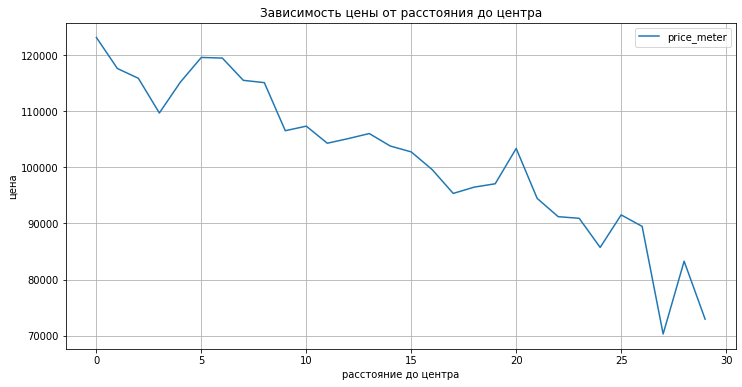

In [ ]:
center_price_to_km_center_spb  = df_spb.pivot_table(index='cityCenters_km',values='price_meter',aggfunc='mean')
center_price_to_km_center_spb.plot(grid=True,title = 'Зависимость цены от расстояния до центра',figsize=(12,6));
plt.xlabel('расстояние до центра');
plt.ylabel('цена');

<BR> *судя по графику, меняющему свое направление*
<BR> *я бы предположил, что зона центра города заканчивается на изломе второй вершины*
<BR> *это район до 5 км*


## 4.5  Выделим сегмент квартир в центре. Отличаются ли они от общих выводов по всему городу?

In [ ]:
df_spb_center = df_spb.query('cityCenters_km <= 5')
df_spb_center

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,year,month,floor_category,living_to_total,kitchen_to_total,cityCenters_km
24,8,6500000.0,97.2,2015-10-31,2,NaN,3.0,46.5,1,NaN,False,False,19.60,0.0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0,66872.427984,5,2015,10,первый,0.478395,0.201646,2.0
61,18,7990000.0,74.0,2017-08-24,2,NaN,4.0,43.0,4,NaN,False,False,20.00,0.0,Санкт-Петербург,22568.0,4288.0,1.0,363.0,0.0,NaN,609.0,107972.972973,3,2017,8,последний,0.581081,0.270270,4.0
99,32,9600000.0,90.0,2017-09-26,4,NaN,5.0,67.0,2,NaN,False,False,8.00,0.0,Санкт-Петербург,23277.0,2818.0,0.0,NaN,0.0,NaN,104.0,106666.666667,1,2017,9,другой,0.744444,0.088889,3.0
136,16,6500000.0,51.8,2018-08-01,2,3.45,6.0,25.6,2,NaN,False,False,7.30,1.0,Санкт-Петербург,20502.0,3618.0,2.0,533.0,1.0,812.0,163.0,125482.625483,2,2018,8,другой,0.494208,0.140927,4.0
138,8,4800000.0,40.0,2017-11-18,2,NaN,3.0,29.0,2,NaN,False,False,6.00,0.0,Санкт-Петербург,23371.0,2913.0,0.0,NaN,2.0,729.0,80.0,120000.000000,5,2017,11,другой,0.725000,0.150000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23644,7,4990000.0,62.5,2018-04-26,2,2.70,4.0,32.3,4,NaN,False,False,12.10,0.0,Санкт-Петербург,20141.0,4415.0,1.0,560.0,1.0,171.0,166.0,79840.000000,3,2018,4,последний,0.516800,0.193600,4.0
23648,14,10100000.0,78.0,2017-05-12,3,3.27,5.0,48.6,5,NaN,False,False,8.20,0.0,Санкт-Петербург,20933.0,1113.0,1.0,621.0,2.0,117.0,621.0,129487.179487,4,2017,5,последний,0.623077,0.105128,1.0
23665,11,4250000.0,47.0,2016-05-20,1,NaN,6.0,18.2,1,False,False,False,14.60,0.0,Санкт-Петербург,20503.0,4946.0,2.0,624.0,1.0,519.0,131.0,90425.531915,4,2016,5,первый,0.387234,0.310638,5.0
23691,11,9470000.0,72.9,2016-10-13,2,2.75,25.0,40.3,7,NaN,False,False,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0,129903.978052,3,2016,10,другой,0.552812,0.145405,4.0


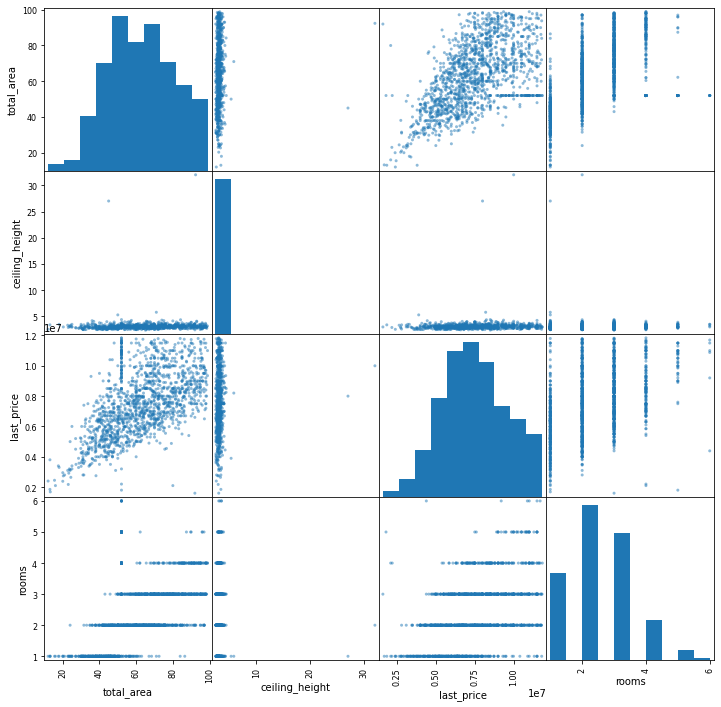

In [ ]:
df_spb_center_analiz = df_spb_center[['total_area','ceiling_height','last_price','rooms']]
pd.plotting.scatter_matrix(df_spb_center_analiz, figsize=(12,12));

In [ ]:
df_spb_center_analiz.corr()

,total_area,ceiling_height,last_price,rooms
total_area,1.000000,0.051511,0.558691,0.576936
ceiling_height,0.051511,1.000000,0.061535,-0.013572
last_price,0.558691,0.061535,1.000000,0.439883
rooms,0.576936,-0.013572,0.439883,1.000000


<BR> *по матрице корреляции можно сделать вывод, корреляция есть*
<BR> *между ценой и общей площадью, чем больше метров, тем больше и цена*
<BR> *между количеством комнат и площадью, чем больше комнат, тем больше и площадь, логично*
<BR> *и соответственно между количеством комнат и ценой*
   

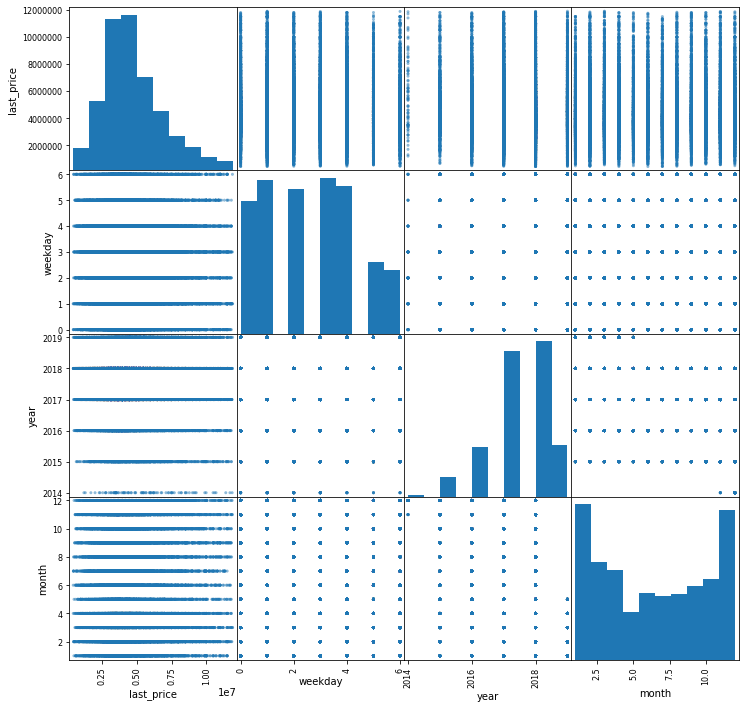

In [ ]:
df_spb_center_to_date = df_spb_center[['last_price','weekday','year','month']]
pd.plotting.scatter_matrix(price_to_date, figsize=(12,12));

In [ ]:
df_spb_center_to_date.corr()

,last_price,weekday,year,month
last_price,1.000000,0.011844,0.020758,-0.057549
weekday,0.011844,1.000000,-0.000973,0.057221
year,0.020758,-0.000973,1.000000,-0.217728
month,-0.057549,0.057221,-0.217728,1.000000


*взаимосвязи времени продажи и ценой в центре, так же не наблюдается*

In [ ]:
df_spb_center.corr()['last_price'].sort_values(ascending=False).head(5)

last_price      1.000000
total_area      0.558691
living_area     0.544202
rooms           0.439883
kitchen_area    0.360503
Name: last_price, dtype: float64

In [ ]:
df_spb.corr()['last_price'].sort_values(ascending=False).head(5)

last_price      1.000000
total_area      0.759088
living_area     0.637985
kitchen_area    0.517071
rooms           0.494295
Name: last_price, dtype: float64

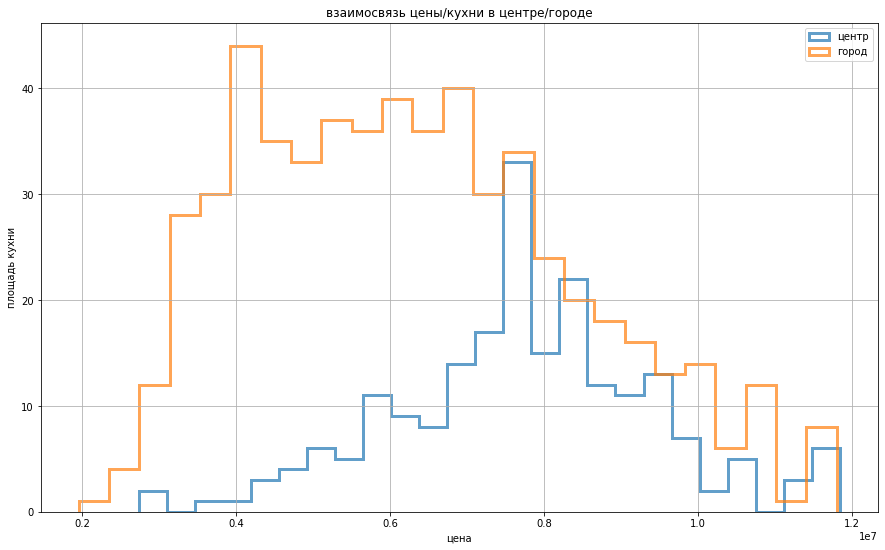

In [ ]:
# кухня центра и города

df_spb_center_2 = df_spb_center.pivot_table(index="kitchen_area", values="last_price", aggfunc="mean")
df_spb_2 = df_spb.pivot_table(index="kitchen_area", values="last_price", aggfunc="mean")

ax = df_spb_center_2.plot(kind='hist', y='last_price',histtype='step',bins=25,linewidth=3,alpha=0.7,label='центр',figsize=(15,9));
df_spb_2.plot(kind='hist', y='last_price',histtype='step',bins=25,linewidth=3,ax=ax,alpha=0.7,label='город',grid=True,legend=True,figsize=(15,9));
plt.title('взаимосвязь цены/кухни в центре/городе')
plt.xlabel('цена');
plt.ylabel('площадь кухни');
plt.show()

<BR> *в целом по городу и в центре, зависимости цены к различным факторам - одинаковы*
<BR> *есть лишь пара небольших различий*
<BR> *в центре чуть больше ценят метраж кухни*
<BR>   

# Шаг 5. Общий вывод

<BR> - *если продать квартиру не удалось за 500 дней, такую продужу можно называть долгой,*
<BR> - *если продажа прошла за 45 дней, то это быстрая продажа*
<BR> - *с каждым годом, количество продаж жилой недвижимости возрастает*
<BR> - *последние этажи, более престижные*
<BR> - *самое дорогое жилье в городе Санкт-Петербург*
<BR> - *самое дешовое жилье можно найти в Выборге*
<BR> - *центр Санкт-Петербурга можно очертить радиусом в 5 км*
<BR> - *в центре города на стоимость влияет чуть больше размер кухни, в городе - количество комнат*
<BR>  
